In [1]:
#import all necessary packages
import pandas as pd
import hypernetx as hnx
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, fpmax
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math
from matplotlib.colors import BoundaryNorm, ListedColormap
from hypergraphx.measures.eigen_centralities import *

/Users/user/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Step 1. Generating Transactions from Mobility Dataset

In [2]:
# Path to the mobility dataframe with movements of 100,000 individuals over 75-day business as usual period
dataset_path = 'YJMob100k/yjmob100k-dataset1.csv' 
# The original dataset has 200x200 grid (area of a grid cell = 1/2 km x1/2 km = 0.25 km^2)
# Scaling_factor 10 (200/10 x 200/10) aggregates it to a 20x20 grid (area of a grid cell = 5 km x 5 km = 25 km^2)
scaling_factor = 10
# List of minimum support thresholds considered [1%, 1.5%, 2%]
min_sups = [0.005, 0.01, 0.015] #minimum support values corresponding to 1% and 1.5% respectively
deltaT_vals = [1, 3, 7] #Sliding window lengths

In [3]:
def read_transactions_from_file(filename):
    transactions = []
    
    with open(filename, "r") as f:
        for line in f:
            # Strip newline and split by commas to get pairs as strings
            pairs = line.strip().split("; ")
            
            # Convert each pair from string to a tuple of integers
            transaction = frozenset(
                tuple(map(int, pair.strip("()").split(","))) for pair in pairs
            )
            transactions.append(transaction)
    
    print(f"Loaded {len(transactions)} transactions from {filename}")
    return transactions

# Step 2. Computing Frequent Itemsets from Transactions Using FPGrowth

In [4]:
def read_freq_itemsets(deltaT, min_sup, file_path):
    # Define the filename based on deltaT and min_sup values
    filename = f"{file_path}freq_itemsets_deltaT_{deltaT}_minsup_{min_sup}.csv"
    
    try:
        # Read the CSV file
        freq_itemsets_df = pd.read_csv(filename)
        print(f"Successfully loaded {filename}")
        
        # Convert 'itemsets' column entries from frozenset string format to normal set
        def parse_to_set(item):
            # Remove 'frozenset({' and '})' to get the string representation of the set's contents
            item = item.strip("frozenset({})")
            
            # Now, split the string by '), (' to separate each tuple, then re-parse each tuple
            items = item.split("), (")
            
            # Convert each string tuple into an actual tuple and collect them into a set
            item_set = set()
            for i in items:
                # Convert each string (e.g., '13, 9') into a tuple (13, 9)
                item_set.add(tuple(map(int, i.split(", "))))
            
            return item_set

        # Apply the parsing function to the 'itemsets' column
        freq_itemsets_df['itemsets'] = freq_itemsets_df['itemsets'].apply(parse_to_set)
        freq_itemsets_df = freq_itemsets_df.reset_index(drop=True)
        return freq_itemsets_df
    except FileNotFoundError:
        print(f"Error: The file {filename} does not exist.")
        return None

In [5]:
# Test
file_path = "outputs/DS1/"
freq_itemsets = read_freq_itemsets(1, 0.005, file_path)
freq_itemsets = freq_itemsets.sort_values(by = 'support', ascending = False)
freq_itemsets.reset_index(drop = True)

Successfully loaded outputs/DS1/freq_itemsets_deltaT_1_minsup_0.005.csv


itemsets   support
0    {(14, 8), (14, 9)}  0.052503
1    {(13, 9), (14, 9)}  0.037677
2    {(13, 9), (14, 8)}  0.031125
3    {(13, 8), (14, 8)}  0.028244
4    {(13, 8), (13, 9)}  0.026129
..                  ...       ...
314    {(6, 1), (5, 1)}  0.005038
315  {(7, 12), (8, 12)}  0.005037
316  {(16, 8), (14, 9)}  0.005031
317  {(13, 5), (14, 5)}  0.005011
318  {(7, 15), (7, 14)}  0.005003

[319 rows x 2 columns]

In [6]:
# Function to check if an itemset is a subset of another
def is_subset(itemset, other_itemset):
    return itemset.issubset(other_itemset)

In [7]:
# Filter for maximal itemsets
def filter_maximal_itemsets(freq_itemsets):
    max_freq_itemsets = []
    for i, row in freq_itemsets.iterrows():
        is_maximal = True
        for j, other_row in freq_itemsets.iterrows():
            if i != j and is_subset(row['itemsets'], other_row['itemsets']):
                is_maximal = False
                break
        if is_maximal:
            max_freq_itemsets.append((row['itemsets'], row['support']))

    # Create a new dataframe with maximal itemsets
    max_freq_itemsets_df = pd.DataFrame(max_freq_itemsets, columns=['itemsets', 'support'])
    return max_freq_itemsets_df

# Step 3. Constructing Hypergraphs from Frequent Itemsets

In [8]:
def construct_hypergraph_from_frequent_itemsets(frequent_itemsets):
    # Extract itemsets and supports
    hyperedges = frequent_itemsets['itemsets'].tolist()
    supports = frequent_itemsets['support'].tolist()
    
    # Construct dictionary for hypergraph with just nodes per edge initially
    hypergraph_dict = {f"{i}": list(edge) for i, edge in enumerate(hyperedges)}
    
    # Create hypergraph
    H = hnx.Hypergraph(hypergraph_dict)
    
    # Add weights to edges in the hypergraph
    for i, support in enumerate(supports):
        H.edges[f"{i}"].weight = support  # Assign weights after hypergraph is constructed

    # Print some info for verification
    print("(#nodes, #edges): ", H.shape)
    
    # Calculate connected components for verification
    #components = H.s_connected_components(edges=True, return_singletons=True)
    #component_sizes = [len(comp) for comp in components]
    #component_sizes = sorted(component_sizes, reverse=True)
    
    #print("# Components: ", len(component_sizes))
    #print("Component sizes:", component_sizes)

    return H, hyperedges

In [9]:
HG = {}
HG_edges = {}
count = 0
for deltaT in deltaT_vals:
    count += 1
    HG[deltaT] = []
    HG_edges[deltaT] = []
    for min_sup in min_sups:
        print(f"Delta T = {deltaT} and min_sup = {min_sup}")
        freq_itemsets = read_freq_itemsets(deltaT, min_sup, file_path)
        print(f"#freq. itemsets = {len(freq_itemsets)}")
        hg, hg_edges = construct_hypergraph_from_frequent_itemsets(freq_itemsets)
        HG[deltaT].append(hg)
        HG_edges[deltaT].append(hg_edges)
        print(f"###########Constructed hypergraph for Delta T = {deltaT} and min_sup = {min_sup} ######")

Delta T = 1 and min_sup = 0.005
Successfully loaded outputs/DS1/freq_itemsets_deltaT_1_minsup_0.005.csv
#freq. itemsets = 319
(#nodes, #edges):  (121, 319)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.005 ######
Delta T = 1 and min_sup = 0.01
Successfully loaded outputs/DS1/freq_itemsets_deltaT_1_minsup_0.01.csv
#freq. itemsets = 78
(#nodes, #edges):  (49, 78)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.01 ######
Delta T = 1 and min_sup = 0.015
Successfully loaded outputs/DS1/freq_itemsets_deltaT_1_minsup_0.015.csv
#freq. itemsets = 20
(#nodes, #edges):  (16, 20)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.015 ######
Delta T = 3 and min_sup = 0.005
Successfully loaded outputs/DS1/freq_itemsets_deltaT_3_minsup_0.005.csv
#freq. itemsets = 3013


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (197, 3013)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.005 ######
Delta T = 3 and min_sup = 0.01
Successfully loaded outputs/DS1/freq_itemsets_deltaT_3_minsup_0.01.csv
#freq. itemsets = 803
(#nodes, #edges):  (135, 803)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.01 ######
Delta T = 3 and min_sup = 0.015
Successfully loaded outputs/DS1/freq_itemsets_deltaT_3_minsup_0.015.csv
#freq. itemsets = 333
(#nodes, #edges):  (94, 333)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.015 ######
Delta T = 7 and min_sup = 0.005


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

Successfully loaded outputs/DS1/freq_itemsets_deltaT_7_minsup_0.005.csv
#freq. itemsets = 31032


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (234, 31032)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.005 ######
Delta T = 7 and min_sup = 0.01
Successfully loaded outputs/DS1/freq_itemsets_deltaT_7_minsup_0.01.csv
#freq. itemsets = 6522


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (186, 6522)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.01 ######
Delta T = 7 and min_sup = 0.015
Successfully loaded outputs/DS1/freq_itemsets_deltaT_7_minsup_0.015.csv
#freq. itemsets = 2587


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (159, 2587)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.015 ######


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1616: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1520718452984677' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self._properties.loc[item_key, prop_name] = prop_val


In [10]:
def create_exclusive_hypergraphs(HG, HG_edges):
    # Create a list to store the exclusive hypergraphs
    exclusive_HG = {}

    for deltaT in HG_edges.keys():
        exclusive_HG[deltaT] = []
        for i in range(0, len(HG_edges[deltaT])):
            hg_edges_i = HG_edges[deltaT][i]
            current_edges = set(tuple(sorted(edge)) for edge in hg_edges_i)
            for j in range(i+1, len(HG_edges[deltaT])):
                hg_edges_j = HG_edges[deltaT][j]
                current_edges -= set(tuple(sorted(edge)) for edge in hg_edges_j)
     
            exc_hg = hnx.Hypergraph({f"{i}": list(edge) for i, edge in enumerate(current_edges)})
  
            print(f"Number of edges exclusive for DeltaT = {deltaT} and min_sup = {min_sups[i]} are: {len(current_edges)}")
            exclusive_HG[deltaT].append(exc_hg)

    return exclusive_HG

In [11]:
exclusive_HG = create_exclusive_hypergraphs(HG, HG_edges)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

Number of edges exclusive for DeltaT = 1 and min_sup = 0.005 are: 241
Number of edges exclusive for DeltaT = 1 and min_sup = 0.01 are: 58
Number of edges exclusive for DeltaT = 1 and min_sup = 0.015 are: 20
Number of edges exclusive for DeltaT = 3 and min_sup = 0.005 are: 2210
Number of edges exclusive for DeltaT = 3 and min_sup = 0.01 are: 470
Number of edges exclusive for DeltaT = 3 and min_sup = 0.015 are: 333
Number of edges exclusive for DeltaT = 7 and min_sup = 0.005 are: 24510
Number of edges exclusive for DeltaT = 7 and min_sup = 0.01 are: 3935
Number of edges exclusive for DeltaT = 7 and min_sup = 0.015 are: 2587


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/p

In [12]:
exclusive_HG_minsup = exclusive_HG[7]
print(exclusive_HG_minsup[1].shape)
for edge_id in exclusive_HG_minsup[1].edges():
    print(edge_id, exclusive_HG_minsup[1].edges[edge_id])

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()


(186, 3935)
0 [(14, 6), (14, 7), (14, 8), (15, 7)]
1 [(16, 6), (16, 8), (17, 7)]
10 [(12, 10), (13, 9), (13, 11), (14, 8), (14, 9)]
100 [(15, 7), (16, 5)]
1000 [(12, 8), (13, 7), (13, 8), (13, 9), (14, 8)]
1001 [(12, 8), (13, 5)]
1002 [(11, 12), (13, 14)]
1003 [(12, 9), (13, 9), (14, 8), (14, 9), (16, 7)]
1004 [(8, 1), (9, 2), (10, 3)]
1005 [(10, 11), (11, 11), (11, 13)]
1006 [(13, 8), (13, 10), (14, 9), (14, 11)]
1007 [(12, 7), (13, 7), (14, 9)]
1008 [(14, 7), (15, 9), (16, 10)]
1009 [(13, 8), (15, 9), (16, 8)]
101 [(12, 10), (14, 7), (14, 8)]
1010 [(16, 7), (17, 6), (19, 5)]
1011 [(10, 11), (11, 10), (12, 8)]
1012 [(14, 10), (15, 8), (16, 9)]
1013 [(9, 11), (9, 13)]
1014 [(14, 9), (15, 9), (16, 8), (17, 9)]
1015 [(12, 13), (12, 14), (13, 9)]
1016 [(13, 8), (13, 9), (13, 10), (14, 11)]
1017 [(11, 10), (15, 11)]
1018 [(11, 8), (13, 8), (14, 9)]
1019 [(14, 9), (19, 11)]
102 [(10, 14), (13, 11)]
1020 [(10, 1), (10, 2)]
1021 [(14, 9), (15, 7), (16, 6), (16, 7)]
1022 [(15, 8), (16, 7), (16

# Step 4. Plot hypergraphs on spatial grid

In [13]:
import hypernetx as hnx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # For custom legend entries

def plot_hypergraphs_with_colored_edges(HG, plot_path, edge_widths, init_radius, 
                                        rad_factor, colors, alpha_values, 
                                        legend_text, DeltaT):
    # Create the figure and axis
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(111)

    # Define the grid size range from 1 to 20
    grid_min, grid_max = 1, 20
    grid_color = 'lightgray'

    # Set axis limits to ensure the grid is between 1 and 20, with a little padding for the box
    ax.set_xlim(grid_min - 0.5, grid_max + 0.5)
    ax.set_ylim(grid_min - 0.5, grid_max + 0.5)

    # Add grid lines from 1 to 20, ensuring they stay within the box
    ax.vlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)
    ax.hlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)

    # Add tick marks on the axes
    for i in range(grid_min, grid_max + 1):
        ax.text(i, grid_min - 0.5, str(i), ha='center', va='top', fontsize=10)  # X-axis labels
        ax.text(grid_min - 0.5, i, str(i), ha='right', va='center', fontsize=10)  # Y-axis labels

    # Configure node labels
    node_labels_kwargs = {
        'fontsize': 4,
        'color': 'k',
        'verticalalignment': 'best',
        'horizontalalignment': 'best',
    }

    # Determine node positions directly from coordinates in node identifiers
    node_set = {node for hypergraph in HG for node in hypergraph.nodes}
    pos = {node: (node[0], node[1]) for node in node_set}

    # Define distinct colors and edge widths for each layer based on support ranges


    # Draw each hypergraph with distinct colors and add a legend
    for i, H in enumerate(HG):
        facecolor_value = (0, 0, 0, alpha_values[i])  # Black face color with variable alpha
        edgecolor_value = colors[i]  # Assign distinct color for each hypergraph layer

        # Draw the hypergraph
        hnx.draw(H, ax=ax, pos=pos, with_edge_labels=False, with_node_labels=False,
                 node_radius=init_radius + math.pow(i, 2) * rad_factor, node_labels_kwargs=node_labels_kwargs,
                 edges_kwargs={'edgecolor': edgecolor_value, 'facecolor': facecolor_value, 'linewidth': edge_widths[i]})

    legend_elements = [Line2D([0], [0], color=colors[i], lw=edge_widths[i], label=legend_text[i])
                       for i in range(len(HG))]

    # Customize the font size of the legend and title
    ax.legend(handles=legend_elements, title="Hypergraph edges by support ranges", loc="upper right",
              fontsize=12, title_fontsize=14)

    # Set the title font size and style
    plt.title(f'Co-visitation Hypergraph for $\Delta T = ${DeltaT} day(s)', fontsize=16, fontweight='bold')

    # Ensure the spines (top, bottom, left, right) are visible and have proper line width
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)  # Set the line width to make it more prominent

    # Remove default grid and adjust layout
    plt.grid(False)
    plt.tight_layout()

    # Save and display the plot
    plt.savefig(plot_path, dpi=600)
    plt.show()

# Example usage:
# plot_hypergraphs_with_colored_edges(HG, 'hypergraphs_distinct_colors.png')


<>:62: DeprecationWarning: invalid escape sequence \D
<>:62: DeprecationWarning: invalid escape sequence \D
/var/folders/z0/wy551r2j0yx_cykzvy1n6hq40000gp/T/ipykernel_46016/1690442863.py:62: DeprecationWarning: invalid escape sequence \D
  plt.title(f'Co-visitation Hypergraph for $\Delta T = ${DeltaT} day(s)', fontsize=16, fontweight='bold')


27 (14, 8)
(24, 130)
8 (14, 8)
(10, 28)
6 (14, 8)
(6, 16)


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1497: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties[self._misc_props_col] = self.properties[
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: Th

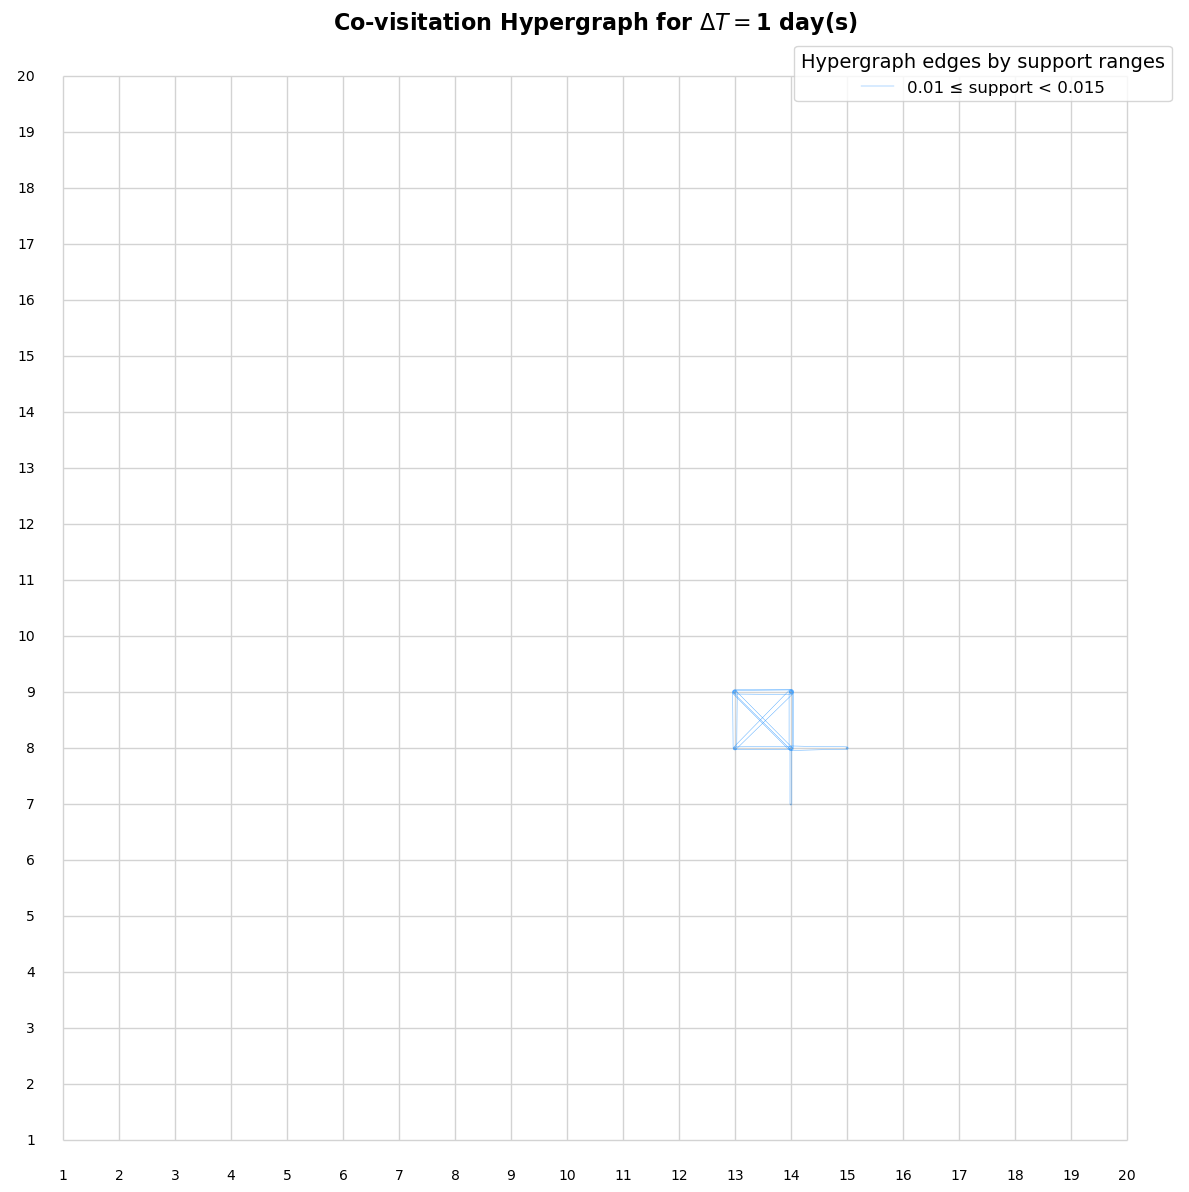

In [14]:
DeltaT = 1
central_node = (14, 8)
exclusive_HG_minsup = exclusive_HG[DeltaT]
central_node_induced_subgraph = []
for i, H in enumerate(exclusive_HG_minsup):
    deg = H.degree(central_node)
    print(deg, central_node)
    immediate_neighbors = set()
    for edge in H.edges:
        edge_members = H.edges[edge].elements
        if central_node in edge_members:
            immediate_neighbors.update(edge_members)
    #print(f"Immediate neighbors of {central_node} in H{i} are {immediate_neighbors}")
    induced_nodes = immediate_neighbors
    #print(f"Induced nodes: {induced_nodes}")
    subgraph = H.restrict_to_nodes(induced_nodes)
    print(subgraph.shape)
    central_node_induced_subgraph.append(subgraph)
    
edge_widths = [0.25, 0.4] 
init_radius = 0.2
rad_factor = 0.0075
colors = ['dodgerblue']
alpha_values = [0.0005, 0.001] 
legend_text = ['0.01 ≤ support < 0.015', 'support ≥ 0.015']
plot_hypergraphs_with_colored_edges(central_node_induced_subgraph[2:],
            f'hypergraph_plot_minsup_all_{DeltaT}_ds1.png', edge_widths,
            init_radius, rad_factor, colors, alpha_values, legend_text, DeltaT
)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1494: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

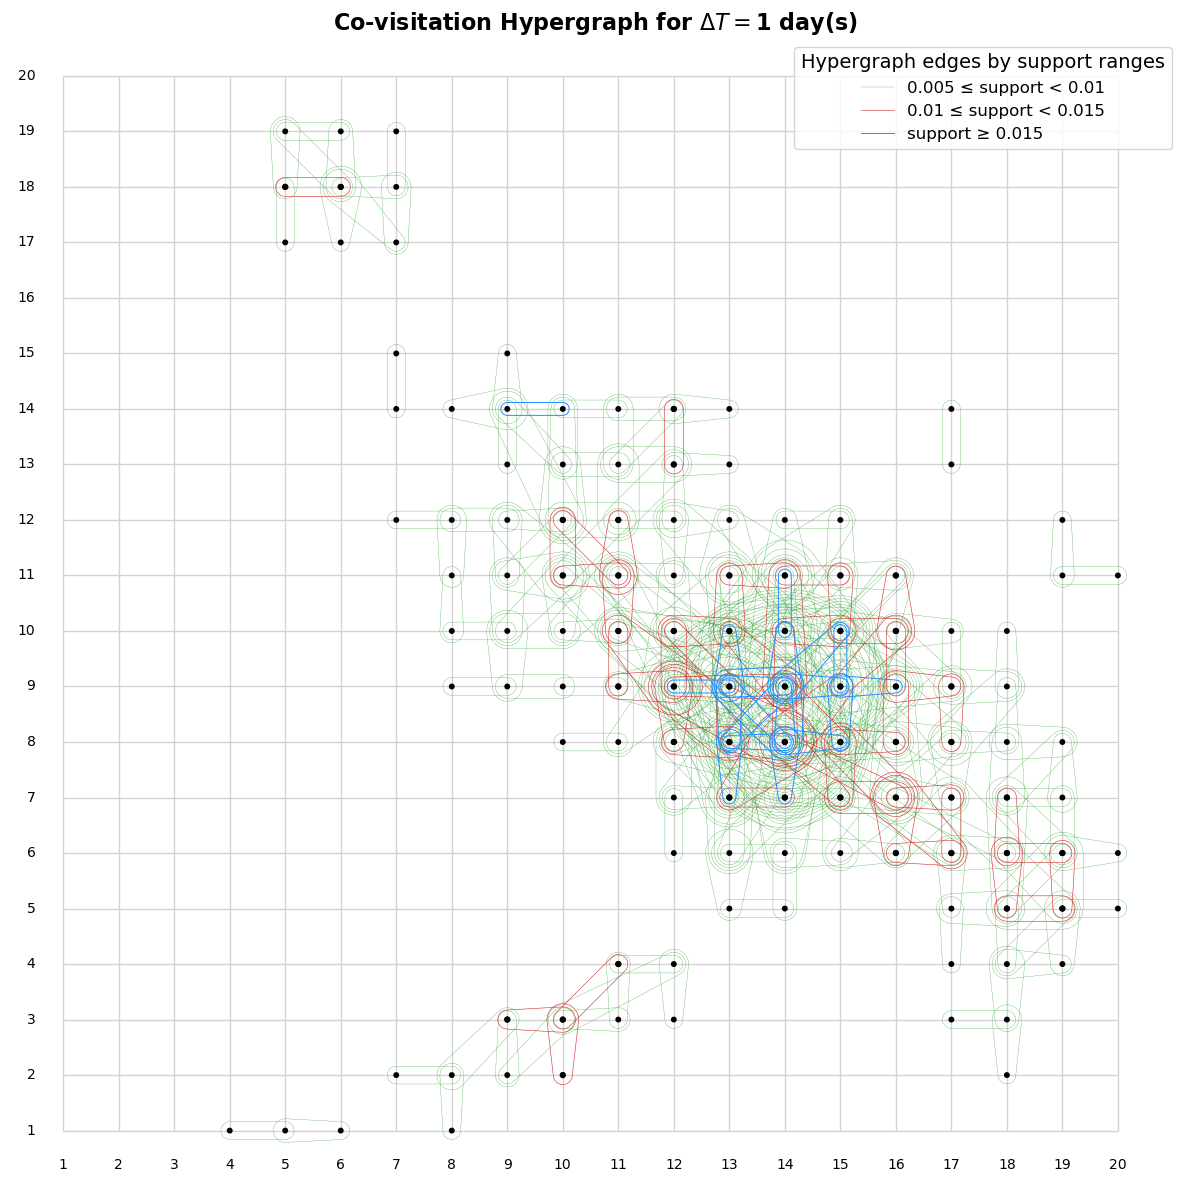

In [15]:
DeltaT = 1
exclusive_HG_minsup = exclusive_HG[DeltaT]
edge_widths = [0.2, 0.4, 0.7] 
init_radius = 0.2
rad_factor = 0.04
colors = ['tab:green', 'tab:red', 'dodgerblue']
alpha_values = [0.0001, 0.0005, 0.001] 
legend_text = ['0.005 ≤ support < 0.01', '0.01 ≤ support < 0.015', 'support ≥ 0.015']
plot_hypergraphs_with_colored_edges(exclusive_HG_minsup,
            f'hypergraph_plot_minsup_all_{DeltaT}_ds1.png', edge_widths,
            init_radius, rad_factor, colors, alpha_values, legend_text, DeltaT
)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()


(197, 2210)
(133, 470)


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1494: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

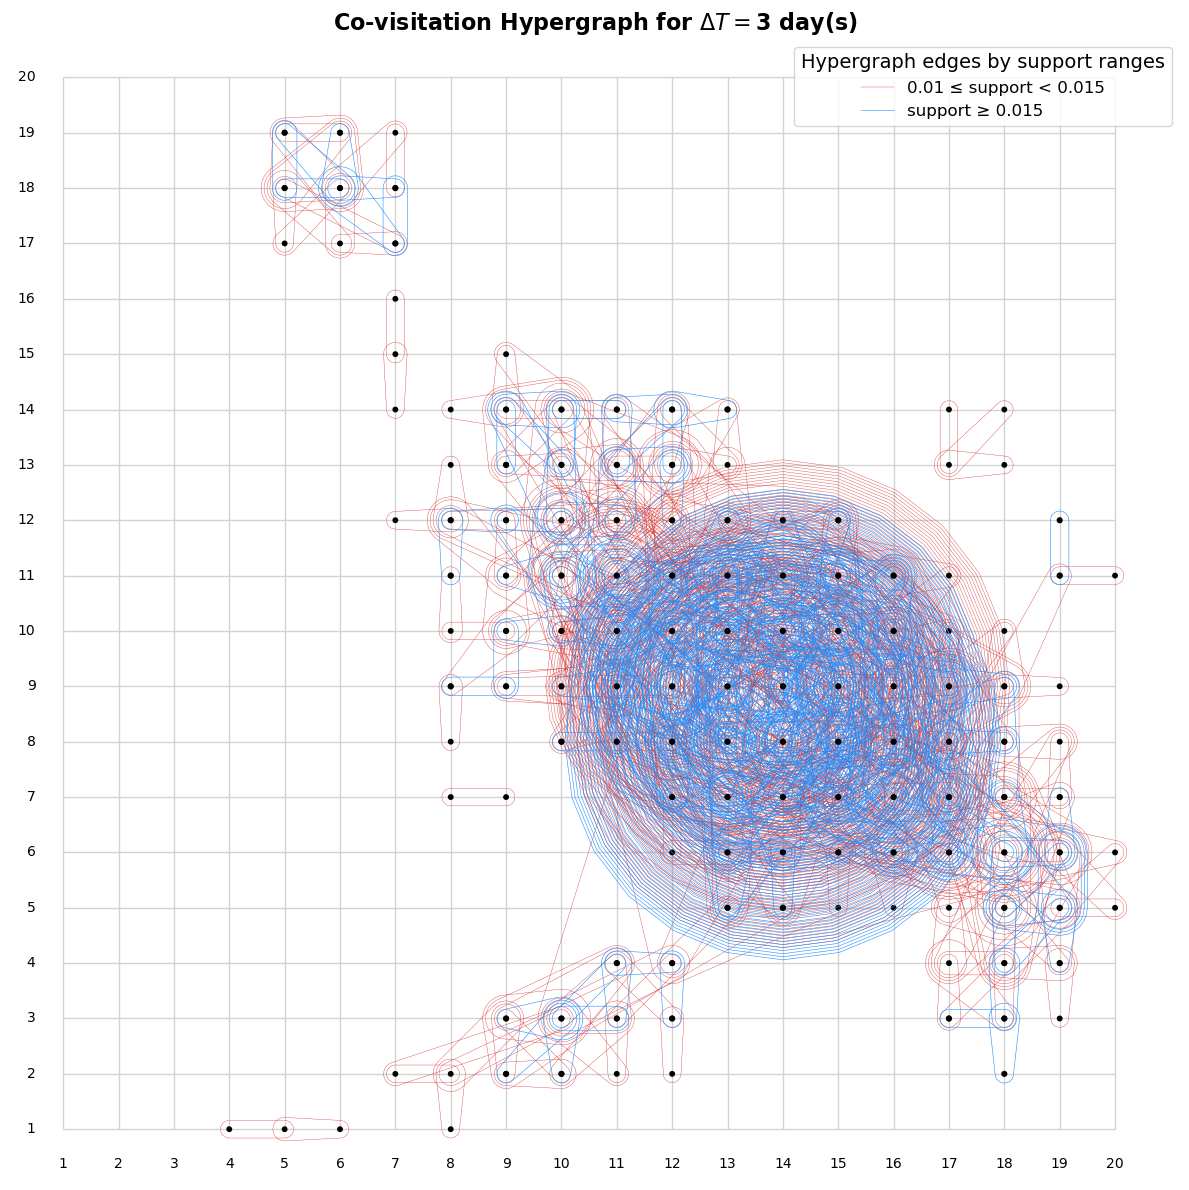

In [16]:
DeltaT = 3
exclusive_HG_minsup = exclusive_HG[DeltaT]
print(exclusive_HG_minsup[0].shape)
print(exclusive_HG_minsup[1].shape)
edge_widths = [0.25, 0.4] 
init_radius = 0.2
rad_factor = 0.0075
colors = ['tab:red', 'dodgerblue']
alpha_values = [0.0005, 0.001] 
legend_text = ['0.01 ≤ support < 0.015', 'support ≥ 0.015']
plot_hypergraphs_with_colored_edges(exclusive_HG_minsup[1:], 
                        f'hypergraph_plot_minsup_2and3_{DeltaT}_ds1.png',
                        edge_widths, init_radius, rad_factor, colors, alpha_values, 
                        legend_text, DeltaT
)

# Step 5. Plot comparison of hypergraph structural properties 

In [17]:
def compute_degree_frequencies(hyperedges):
    degree_count = defaultdict(int)

    for edge in hyperedges:
        for node in edge:
            degree_count[node] += 1
    max_degree = max(degree_count.values())
    
    # Count the frequency of each degree
    degree_freq = defaultdict(int)
    for degree in degree_count.values():
        degree_freq[degree] += 1

    # Sort the degrees and their frequencies
    sorted_degrees = sorted(degree_freq.keys())
    sorted_frequencies = [degree_freq[degree] for degree in sorted_degrees]
    print(sorted_degrees)
    print(sorted_frequencies)
    return sorted_degrees, sorted_frequencies, degree_count

In [18]:
degrees = {}
frequencies = {}
degree_counts = {}

In [19]:
for DeltaT in HG_edges.keys():
    HG_edges_DeltaT = HG_edges[DeltaT]
    degrees[DeltaT] = []
    frequencies[DeltaT] = []
    degree_counts[DeltaT] = []
    for i in range(len(HG_edges[DeltaT])):
        print(f"Degree Distribution of hypergraph for DeltaT = {DeltaT} and min_sup = {min_sups[i]}")
        degs, freqs, deg_counts = compute_degree_frequencies(HG_edges_DeltaT[i])
        degrees[DeltaT].append(degs)
        frequencies[DeltaT].append(freqs)
        degree_counts[DeltaT].append(deg_counts)

Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.005
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 20, 22, 30, 41, 44]
[30, 14, 17, 12, 8, 7, 9, 4, 2, 3, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1]
Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.01
[1, 2, 3, 4, 5, 6, 8, 12, 14]
[13, 14, 7, 6, 1, 3, 3, 1, 1]
Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.015
[1, 2, 4, 6, 7]
[8, 3, 2, 2, 1]
Degree Distribution of hypergraph for DeltaT = 3 and min_sup = 0.005
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 46, 50, 51, 53, 55, 56, 61, 64, 65, 70, 71, 74, 78, 81, 83, 85, 92, 93, 98, 99, 104, 114, 117, 132, 133, 137, 139, 144, 150, 159, 164, 176, 244, 246, 247, 269, 375, 469, 502]
[15, 13, 10, 9, 9, 6, 5, 3, 6, 5, 8, 5, 4, 3, 2, 3, 1, 1, 2, 1, 3, 3, 2, 5, 2, 1, 2, 2, 3, 2, 1, 1, 4, 1, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [20]:
def calculate_ccdf(degrees, frequencies):
    """
    Calculate the CCDF for each degree distribution.
    
    Parameters:
    degrees (list): List of degrees in the network.
    frequencies (list): Frequency of each degree.
    
    Returns:
    sorted_degrees (list): Sorted degrees.
    ccdf (list): CCDF values corresponding to the sorted degrees.
    """
    sorted_degrees = np.array(sorted(degrees))
    sorted_frequencies = np.array([frequencies[degrees.index(d)] for d in sorted_degrees])
    
    # Calculate cumulative counts from the largest degree downwards
    cumulative_counts = np.cumsum(sorted_frequencies[::-1])[::-1]
    ccdf = cumulative_counts / cumulative_counts[0]  # Normalize to get CCDF
    
    return sorted_degrees, ccdf

def plot_degree_distribution_ccdf(degrees, frequencies, min_sup_value, plot_path):
    """
    Plots CCDF of degree distributions on a log-log scale for the first min_sup value for each Delta T.

    Parameters:
    degrees (dict): Dictionary where each key is a ΔT value, and each value is a list of lists of degrees for each min_sup.
    frequencies (dict): Dictionary where each key is a ΔT value, and each value is a list of lists of frequencies of degrees for each min_sup.
    min_sup_value (float): The minimum support value used for the first element in each list.
    plot_path (str): Path to save the plot image.
    """
    # Define markers for visual distinction, and set all curves to black
    markers = ['o', 's', '^', 'D', 'v', 'p', '*']
    colors = ['tab:green', 'tab:blue', 'tab:red']
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Track index for marker selection
    marker_idx = 0

    # Loop over each ΔT value and plot only the first min_sup level
    i = 0
    for delta_t in degrees.keys():
        if delta_t not in frequencies:
            print(f"Warning: ΔT={delta_t} is missing in frequencies")
            continue
        
        # Take only the first min_sup value for the plot
        degree_list = degrees[delta_t][0]
        frequency_list = frequencies[delta_t][0]

        # Calculate CCDF
        sorted_degrees, ccdf = calculate_ccdf(degree_list, frequency_list)
        
        # Choose marker, cycling if we run out of distinct options
        marker = markers[marker_idx % len(markers)]
        label = f"ΔT={delta_t}"
        
        # Plot the CCDF curve in black with the specified marker
        ax.plot(
            sorted_degrees, ccdf,
            color=colors[i], linewidth=1.5, linestyle='-', marker=marker, markersize=2,
            label=label
        )
        
        # Increment marker index
        marker_idx += 1
        i += 1
    # Set logarithmic scales for both axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Set labels and title
    ax.set_xlabel('Degree (Number of hyperedges incident on a node)', fontsize=12)
    ax.set_ylabel(r'P(Degree ≥ k)', fontsize=12)  # Updated y-axis label with probability notation
    ax.set_title(f'CCDF of Degree Distribution for Various ΔT Values (min_sup={min_sup_value})', fontsize=14)
    
    # Configure legend and display plot
    ax.legend(title="ΔT values", loc="upper right", fontsize=10)
    plt.tight_layout()
    plt.savefig(plot_path, dpi=600)
    plt.show()

# Example usage:
# plot_degree_distribution_ccdf(degrees, frequencies, min_sup_value=0.005, plot_path='degree_distribution_ccdf.png')


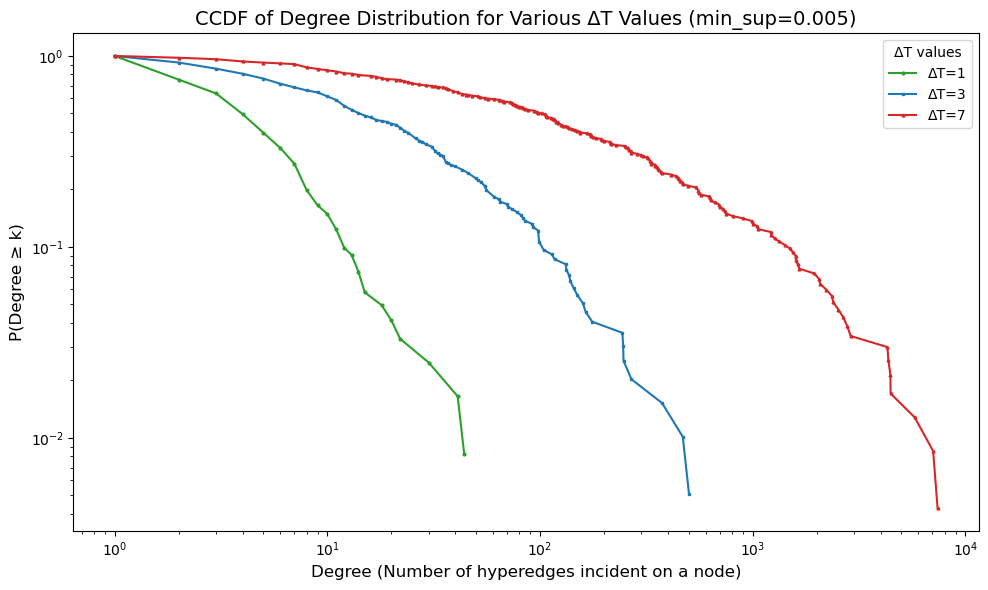

In [21]:
plot_path = 'degree_distribution_comparison_minsup_0.005_ds1.png'
plot_degree_distribution_ccdf(degrees, frequencies, 0.005, plot_path)

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_hyperedge_size_distribution(hg_edges, plot_path):
    """
    Plots the hyperedge size distribution for min_sup = 0.005 for each ΔT value.
    Annotates each bar with the exact count on top of the bars.

    Parameters:
    hg_edges (dict): Dictionary with ΔT values as keys and a list of lists of hyperedges for each min_sup.
    plot_path (str): Path to save the plot image.
    """
    # Define the color for each ΔT value
    colors = ['seagreen', 'tab:red', 'dodgerblue']
    legend_text = ['ΔT = 1', 'ΔT = 3', 'ΔT = 7']

    # Collect all unique hyperedge sizes across all ΔT values for min_sup = 0.005
    all_sizes = set()
    size_freqs = []

    # Loop through the ΔT values and take the first min_sup (index 0)
    for delta_t in hg_edges:
        # Only consider the first min_sup value (index 0)
        hyperedges = hg_edges[delta_t][0]
        hyperedge_size = [len(edge) for edge in hyperedges]  # Get the size of each hyperedge
        size_freq = {}

        for size in hyperedge_size:
            if size not in size_freq:
                size_freq[size] = 0
            size_freq[size] += 1

        size_freqs.append(size_freq)
        all_sizes.update(size_freq.keys())  # Add the sizes to the set of all sizes

    # Sort all sizes for consistent plotting order
    all_sizes = sorted(all_sizes)

    # Prepare data for the bar plot
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(all_sizes))  # x-axis positions for each hyperedge size
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each ΔT value's data for min_sup = 0.005
    for i, (size_freq, label, color) in enumerate(zip(size_freqs, legend_text, colors)):
        # Get frequencies for each size, using 0 for sizes not in the current hypergraph
        frequencies = [size_freq.get(size, 0) for size in all_sizes]

        # Skip sizes with zero frequency for log scale plot
        frequencies = [f for f in frequencies if f > 0]
        valid_sizes = [size for size, freq in zip(all_sizes, frequencies) if freq > 0]

        # Skip plotting if all frequencies are zero
        if len(frequencies) == 0:
            continue

        # Create bars for the valid sizes
        bars = ax.bar(x[:len(frequencies)] + i * bar_width - (len(hg_edges) - 1) * bar_width / 2, 
                      frequencies, width=bar_width, label=label, color=color)

        # Annotate each bar with the exact frequency value on top of the bar
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add annotations for bars with non-zero height
                ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, str(int(height)),
                        ha='center', va='bottom', fontsize=7)

    # Set logarithmic scale for y-axis
    ax.set_yscale('log')

    # Customize the plot
    ax.set_xticks(x[:len(frequencies)])  # Adjust x-ticks to only show valid sizes
    ax.set_xticklabels(valid_sizes)  # Update x-tick labels to match valid sizes
    ax.set_xlabel('Hyperedge Size (Number of nodes)', fontsize=12)
    ax.set_ylabel('Frequency (Log Scale)', fontsize=12)
    ax.set_title('Hyperedge Size Distribution for min_sup = 0.005 across Different ΔT Values', fontsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer labels on x-axis

    # Add legend
    ax.legend(title='ΔT values', loc='upper right', fontsize=10)

    # Save and show plot
    plt.tight_layout()
    plt.savefig(plot_path, dpi=600)
    plt.show()

# Example usage:
# Assuming `hg_edges` is your dictionary with ΔT values as keys and lists of hyperedges for each min_sup
# hg_edges = {1: [[edge1, edge2, edge3], ...], 3: [[edge4, edge5], ...], 7: [[edge6, edge7, edge8], ...]}
# plot_hyperedge_size_distribution(hg_edges, plot_path='hyperedge_size_distribution_min_sup_0_005.png')


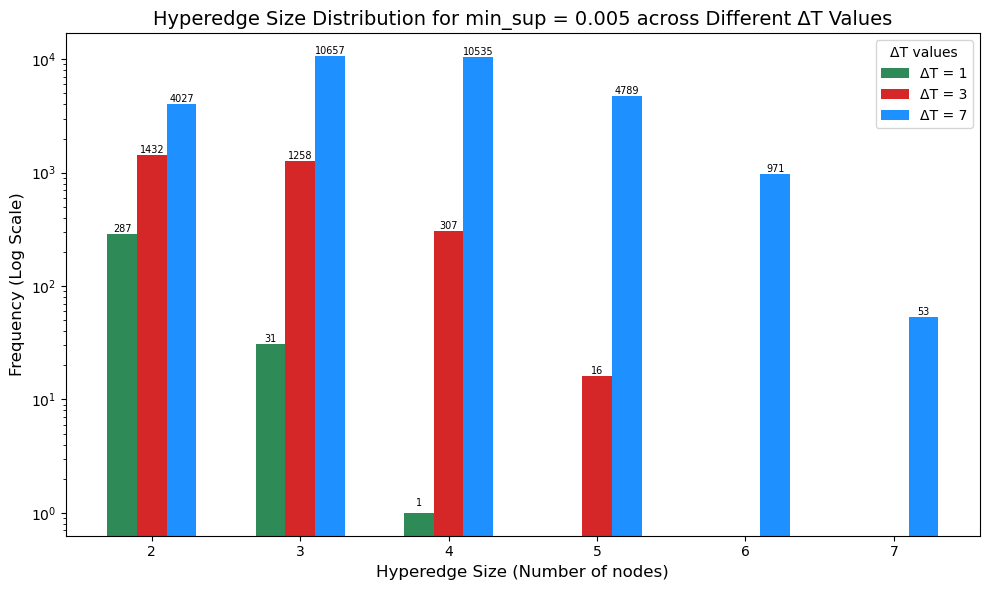

In [23]:
plot_path = 'hyperedge_size_distribution_minsup_0.005_ds1.png'
plot_hyperedge_size_distribution(HG_edges, plot_path)

In [24]:
def plot_heat_map_of_node_degree(degree_count, delta_t, plot_path, bins, colors):
    """
    Plots a heatmap of node degrees for a single hypergraph with a specified ΔT value,
    using discrete color bins, bounding boxes around cells, and small spaces between cells.
    
    Parameters:
    degree_count (dict): Dictionary representing degree counts of nodes for a single hypergraph.
                         Keys are (x, y) coordinates, values are degree counts.
    delta_t (int): The ΔT value to label the plot.
    plot_path (str): Path to save the plot image.
    """
    # Initialize a 20x20 grid for the heatmap
    degree_grid = np.zeros((20, 20))
    
    # Normalize the bins using BoundaryNorm
    norm = BoundaryNorm(bins, ncolors=len(colors))  # Normalize based on the bins

    # Populate the degree grid based on (x, y) coordinates
    for (x, y), degree in degree_count.items():
        # Assuming (x, y) are within the range [1, 20]
        if 1 <= x <= 20 and 1 <= y <= 20:
            degree_grid[y-1, x-1] = degree  # Fill in the grid (0-indexed)

    # Create the heatmap with discrete color bins and a bounding box around cells
    plt.figure(figsize=(8, 8))
    sns.heatmap(
        degree_grid, fmt='.0f', cmap=colors, norm=norm, cbar=True,
        xticklabels=np.arange(1, 21), yticklabels=np.arange(1, 21),
        cbar_kws={'ticks': bins, 'label': 'Degree Count', 'shrink': 0.6},  # Shrink the color bar
        linewidths=0.5,  # Small line width for spacing between cells
        linecolor='lightgrey',  # Color of the lines around each cell
        square=True  # Ensure that cells are square-shaped
    )

    # Set titles and labels
    plt.title(f'Node Degree Heatmap (ΔT = {delta_t}, min_sup = 0.005)', fontsize=14)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.gca().invert_yaxis()  # Invert y-axis for correct orientation

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(plot_path, dpi=600)
    plt.show()


In [25]:
def generate_adaptive_log_bins(max_deg):
    """
    Generates a list of bin edges for degree counts with the first bin at 0, the second at 1,
    and the remaining bins increasing gradually up to max_deg, using a logarithmic scale.
    
    Parameters:
    max_deg (int): The maximum degree to set as the upper bound for the last bin.
    
    Returns:
    list: A list of bin edges.
    """
    # Determine the total bins as a function of max_deg (using log scale)
    total_bins = int(np.ceil(np.log2(max_deg))) + 2  # +2 to include bins for 0 and 1

    # Start with bins 0 and 1 as the first two bins
    bins = [0, 1]
    
    # Remaining bins to generate
    remaining_bins = total_bins - 2

    # Use a power-based scale to create the remaining bins between 1 and max_deg
    power_base = np.linspace(0, 1, remaining_bins) ** 1.5  # Smooth scaling
    scale_bins = (1 + (max_deg - 1) * power_base).astype(int)  # Shift up to start at 1, end at max_deg

    # Convert scale_bins to integers, rounding and removing duplicates
    bins.extend(np.round(scale_bins).astype(int))
    bins[-1] = max_deg  # Ensure the last bin equals max_deg
    
    # Remove duplicates from rounding
    bins = sorted(set(bins))
    
    return bins

In [26]:
def generate_adaptive_colors(num_bins):
    """
    Generates a list of colors from white to black for the number of bins.
    
    Parameters:
    num_bins (int): The number of colors (bins) to generate.
    
    Returns:
    list: A list of grayscale colors for each bin.
    """
    # Use a 'Greys' color map from matplotlib to generate shades from white to black
    cmap = plt.cm.Reds  # This will generate shades of gray from white to black
    colors = [cmap(i / (num_bins - 1)) for i in range(num_bins)]  # Generate the color scale
    return colors

(14, 8) 41
(14, 9) 44
(14, 9) 44
[0, 1, 4, 11, 20, 31, 44]
[(1.0, 0.9607843137254902, 0.9411764705882353, 1.0), (0.9935870818915802, 0.8323414071510957, 0.7624913494809689, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.6943944636678201, 0.07003460207612457, 0.09231833910034601, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


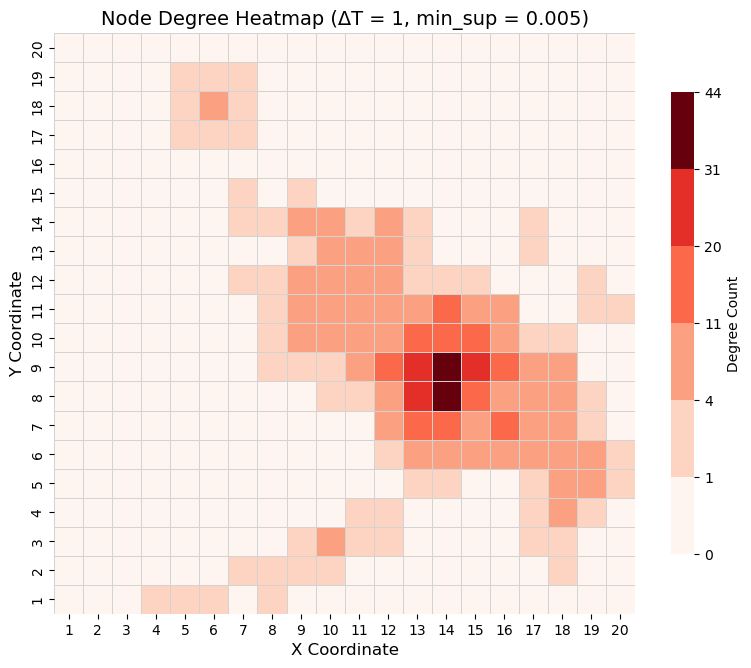

In [27]:
deltaT = 1
degree_count_deltaT = degree_counts[deltaT]
deg_counts = degree_count_deltaT[0]
max_deg = 0
max_deg_node = (-1, -1)
plot_path = f'heat_map_node_degree_deltaT_{deltaT}_minsup_{min_sups[0]}.png'
for node in deg_counts:
    if deg_counts[node] > max_deg:
        max_deg = deg_counts[node]
        max_deg_node = node
    if deg_counts[node] > 40:
        print(node, deg_counts[node])
print(max_deg_node, max_deg)
bins = generate_adaptive_log_bins(max_deg)
colors = generate_adaptive_colors(len(bins))
print(bins)
print(colors)
plot_heat_map_of_node_degree(deg_counts, deltaT, plot_path, bins, colors)

(14, 8) 502
(14, 9) 469
(14, 8) 502
[0, 1, 23, 63, 116, 178, 248, 326, 411, 502]
[(1.0, 0.9607843137254902, 0.9411764705882353, 1.0), (0.996555171088043, 0.8884429065743944, 0.8378316032295271, 1.0), (0.9901422529796232, 0.7686120722798924, 0.6780930411380238, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9860976547481738, 0.48704344482891193, 0.3615532487504806, 1.0), (0.9629065743944636, 0.331841599384852, 0.23667820069204154, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.7598462129950019, 0.0855363321799308, 0.10609765474817377, 1.0), (0.6175009611687813, 0.05167243367935409, 0.07853902345251824, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


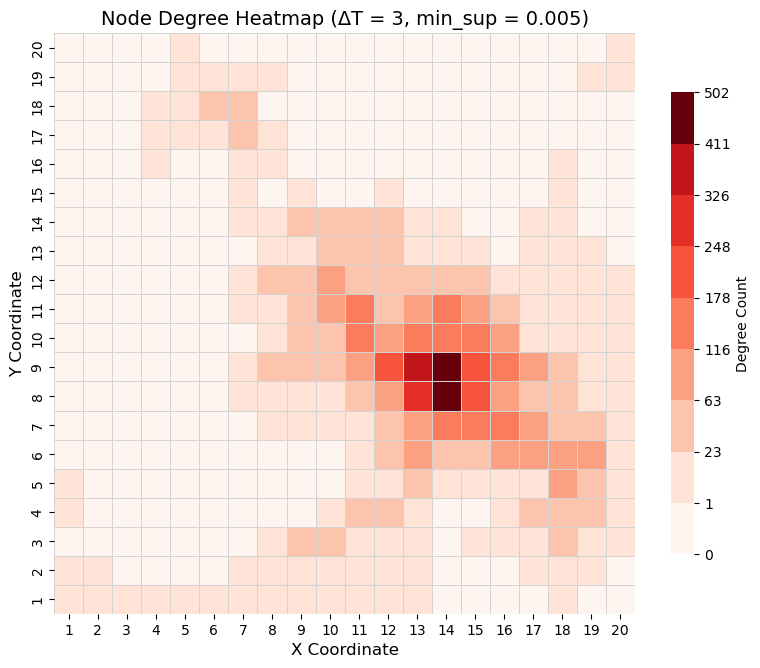

In [28]:
deltaT = 3
degree_count_deltaT = degree_counts[deltaT]
deg_counts = degree_count_deltaT[0]
max_deg = 0
max_deg_node = (-1, -1)
plot_path = f'heat_map_node_degree_deltaT_{deltaT}_minsup_{min_sups[0]}.png'
for node in deg_counts:
    if deg_counts[node] > max_deg:
        max_deg = deg_counts[node]
        max_deg_node = node
    if deg_counts[node] > 450:
        print(node, deg_counts[node])
print(max_deg_node, max_deg)
bins = generate_adaptive_log_bins(max_deg)
colors = generate_adaptive_colors(len(bins))
print(bins)
print(colors)
plot_heat_map_of_node_degree(deg_counts, deltaT, plot_path, bins, colors)

(14, 8) 7402
(14, 9) 7053
(14, 8) 7402
[0, 1, 179, 504, 926, 1425, 1991, 2617, 3298, 4029, 4808, 5631, 6496, 7402]
[(1.0, 0.9607843137254902, 0.9411764705882353, 1.0), (0.9976624375240293, 0.9116955017301038, 0.8710495963091118, 1.0), (0.9943252595155709, 0.845997693194925, 0.7805767012687428, 1.0), (0.9894040753556325, 0.754955786236063, 0.6600076893502499, 1.0), (0.9882352941176471, 0.6614532871972318, 0.5489734717416378, 1.0), (0.9879430988081508, 0.5608612072279893, 0.43537101114955795, 1.0), (0.9854825067281815, 0.46243752402921956, 0.3369473279507882, 1.0), (0.9702883506343714, 0.3607535563244906, 0.25513264129181085, 1.0), (0.9407612456747405, 0.24510572856593618, 0.18131487889273357, 1.0), (0.85919261822376, 0.15547866205305652, 0.1400230680507497, 1.0), (0.7738715878508267, 0.0888581314878893, 0.10905036524413689, 1.0), (0.6803690888119954, 0.06671280276816609, 0.08936562860438292, 1.0), (0.5488504421376394, 0.035063437139561705, 0.06968089196462898, 1.0), (0.403921568627451, 

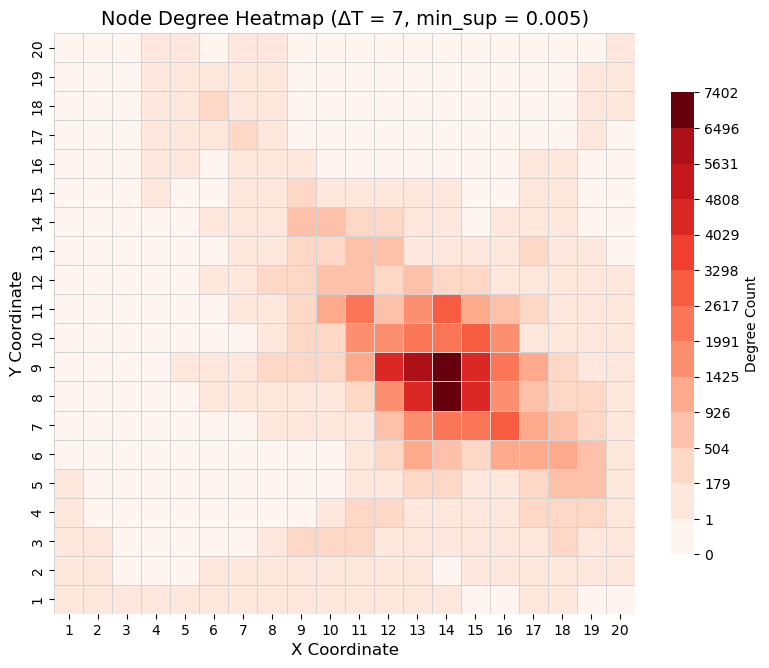

In [29]:
deltaT = 7
degree_count_deltaT = degree_counts[deltaT]
deg_counts = degree_count_deltaT[0]
max_deg = 0
max_deg_node = (-1, -1)
plot_path = f'heat_map_node_degree_deltaT_{deltaT}_minsup_{min_sups[0]}.png'
for node in deg_counts:
    if deg_counts[node] > max_deg:
        max_deg = deg_counts[node]
        max_deg_node = node
    if deg_counts[node] > 7000:
        print(node, deg_counts[node])
print(max_deg_node, max_deg)
bins = generate_adaptive_log_bins(max_deg)
colors = generate_adaptive_colors(len(bins))
print(bins)
print(colors)
plot_heat_map_of_node_degree(deg_counts, deltaT, plot_path, bins, colors)

In [30]:
# Create a dictionary mapping (x, y) to node ids
node_id_map = {}

# Initialize node ID counter
node_id = 1

# Loop through each (x, y) coordinate in the grid from (1, 1) to (20, 20)
for x in range(1, 21):  # x goes from 1 to 20
    for y in range(1, 21):  # y goes from 1 to 20
        node_id_map[(x, y)] = node_id
        node_id += 1

# Print the dictionary for verification
print(len(node_id_map))

400


In [31]:
def plot_k_uniform_subhypergraph(H, k, plot_path, DeltaT):
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)

    # Use node labels directly as (x, y) coordinates
    # Assuming H_order3 nodes are something like (0,0), (5,10), (10,5), etc.
    pos = {node: node for node in H.nodes}  # Node labels are used as positions

    node_labels_kwargs = {
        'fontsize': 10,         # Font size of the node labels
        'color': 'k',        # Color of the node labels
        'verticalalignment': 'top',  # Vertical alignment of the label
        'horizontalalignment': 'left' # Horizontal alignment of the label
    }
    # Draw the hypergraph using the node labels as positions and let edges be drawn normally
    hnx.draw(H, ax=ax, pos=pos, with_edge_labels=False, with_node_labels = True, node_radius=0.2,
         node_labels_kwargs=node_labels_kwargs)
    plot_title = f'{k}-uniform subhypergraph ($\Delta T =$ {DeltaT}, min_sup = {min_sups[0]})'
    plt.title(plot_title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(plot_path, dpi = 600)
    plt.show()

<>:18: DeprecationWarning: invalid escape sequence \D
<>:18: DeprecationWarning: invalid escape sequence \D
/var/folders/z0/wy551r2j0yx_cykzvy1n6hq40000gp/T/ipykernel_46016/360610921.py:18: DeprecationWarning: invalid escape sequence \D
  plot_title = f'{k}-uniform subhypergraph ($\Delta T =$ {DeltaT}, min_sup = {min_sups[0]})'


31


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

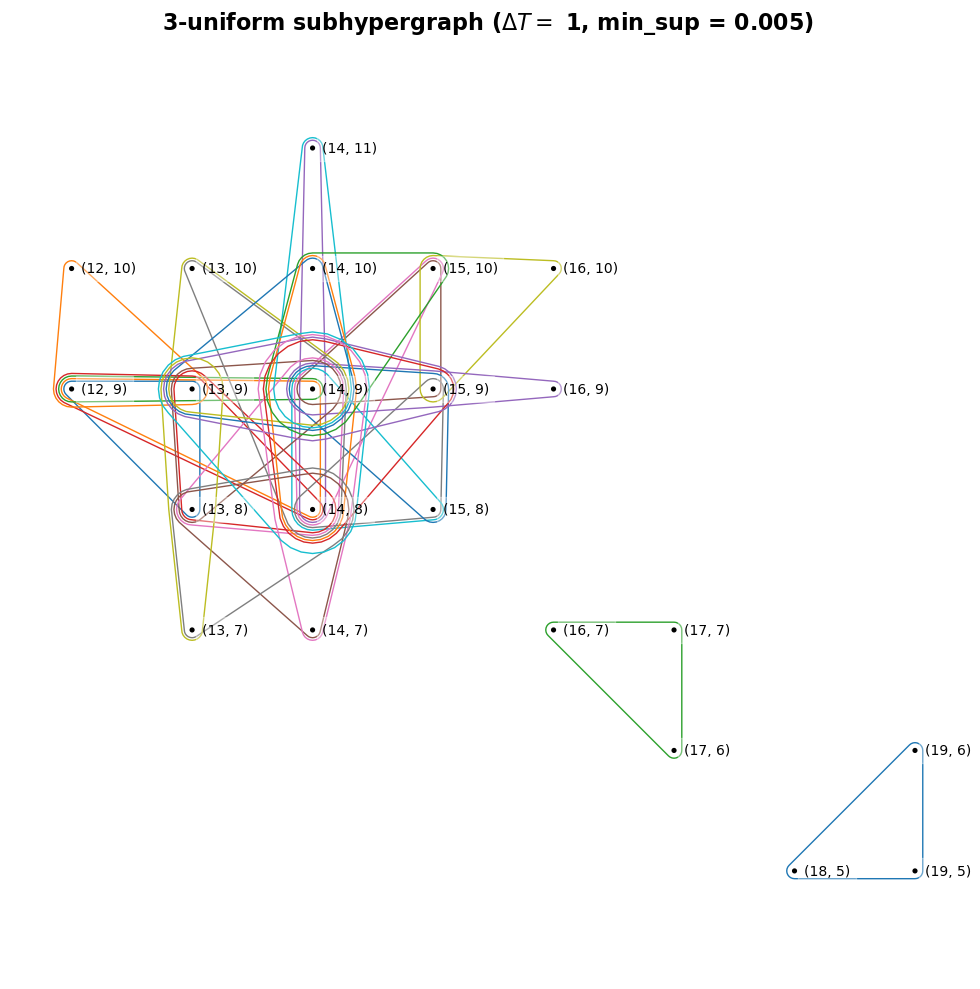

In [32]:
DeltaT = 1
k = 3
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(len(k_uniform_edges))
H_k_uniform = hnx.Hypergraph(k_uniform_edges)
plot_path = f'hg_{k}_uniform_subgraph_deltaT_{DeltaT}_minsup_{min_sups[min_sup_ind]}.png'
plot_k_uniform_subhypergraph(H_k_uniform, k, plot_path, DeltaT)

16


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

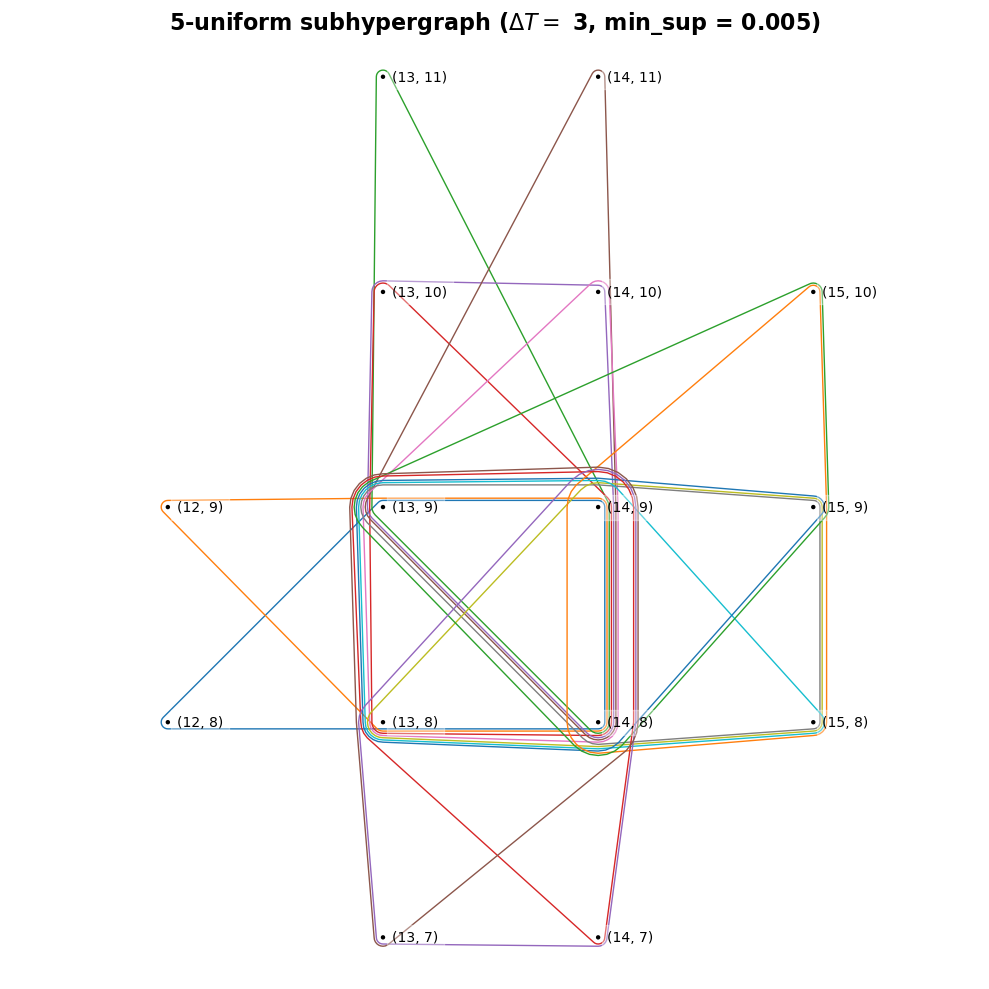

In [33]:
DeltaT = 3
k = 5
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(len(k_uniform_edges))
H_k_uniform = hnx.Hypergraph(k_uniform_edges)
plot_path = f'hg_{k}_uniform_subgraph_deltaT_{DeltaT}_minsup_{min_sups[min_sup_ind]}.png'
plot_k_uniform_subhypergraph(H_k_uniform, k, plot_path, DeltaT)

{'1004': [(14, 8), (13, 10), (14, 10), (15, 10), (13, 9), (14, 9), (14, 11)], '14769': [(13, 8), (14, 8), (14, 10), (12, 9), (13, 9), (14, 9), (14, 11)], '14788': [(13, 8), (14, 8), (14, 10), (12, 9), (13, 9), (14, 9), (15, 9)], '14905': [(13, 8), (14, 8), (14, 10), (15, 10), (13, 9), (14, 9), (14, 11)], '14916': [(13, 8), (14, 8), (14, 10), (15, 10), (13, 9), (14, 9), (15, 9)], '14931': [(13, 8), (14, 8), (14, 10), (13, 9), (14, 9), (15, 9), (14, 11)], '14979': [(14, 8), (15, 8), (14, 10), (15, 10), (14, 9), (15, 9), (14, 11)], '14989': [(14, 8), (15, 8), (14, 10), (15, 10), (13, 9), (14, 9), (15, 9)], '15021': [(13, 8), (14, 8), (15, 8), (14, 10), (13, 9), (14, 9), (15, 9)], '15039': [(14, 8), (15, 8), (14, 10), (13, 9), (14, 9), (15, 9), (14, 11)], '15125': [(14, 8), (14, 10), (15, 10), (13, 9), (14, 9), (15, 9), (14, 11)], '15808': [(13, 8), (14, 8), (15, 8), (13, 9), (14, 9), (15, 9), (14, 11)], '15928': [(13, 8), (14, 8), (15, 8), (16, 9), (13, 9), (14, 9), (15, 9)], '16055': [(1

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

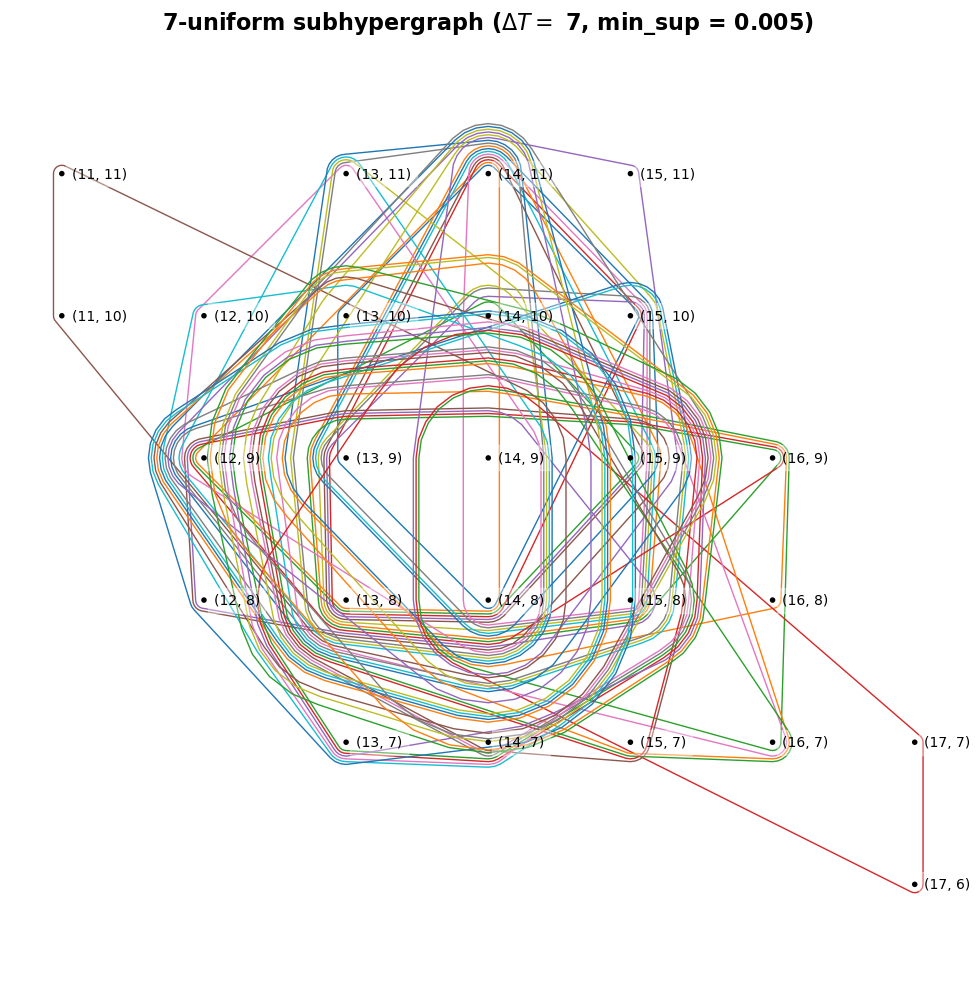

In [34]:
DeltaT = 7
k = 7
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(k_uniform_edges)
H_k_uniform = hnx.Hypergraph(k_uniform_edges)
plot_path = f'hg_{k}_uniform_subgraph_deltaT_{DeltaT}_minsup_{min_sups[min_sup_ind]}.png'
plot_k_uniform_subhypergraph(H_k_uniform, k, plot_path, DeltaT)

In [35]:
def is_moore_neighbour(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return abs(x1 - x2) <= 1 and abs(y1 - y2) <= 1

In [36]:
def filter_edges_by_moore_neighborhood(hypergraph, r):
    filtered_edges = {}

    for edge_id, edge_nodes in hypergraph.incidence_dict.items():
        # Convert edge_nodes to a list of tuples if they aren't already
        edge_nodes = [tuple(node) if isinstance(node, (list, tuple)) else node for node in edge_nodes]
        
        # Check if all nodes in the edge are in each other's Moore neighborhood
        is_in_moore_neighborhood = True
        for node in edge_nodes:
            # For each node, get its Moore neighborhood
            neighbors = moore_neighborhood(*node)
            # Check if every other node in the edge is in this node's neighborhood
            if not all(other_node in neighbors for other_node in edge_nodes if other_node != node):
                is_in_moore_neighborhood = False
                break
        
        # If not all nodes are in each other's neighborhood, keep this edge
        if not is_in_moore_neighborhood:
            x = random.random()
            if x < r:
                filtered_edges[edge_id] = edge_nodes

    # Create a new hypergraph from the filtered edges
    return hnx.Hypergraph(filtered_edges), filtered_edges

In [37]:
def strict_filter_edges(hypergraph, r):
    # Dictionary to store the filtered edges
    filtered_edges = {}
    
    for edge_id, nodes in hypergraph.incidence_dict.items():
        # Check all pairs in the hyperedge to ensure none are in each other's Moore neighborhood
        if all(not is_moore_neighbour(node1, node2) for node1, node2 in combinations(nodes, 2)):
            x = random.random()
            if x < r:
                filtered_edges[edge_id] = nodes  # Add the edge if it passes the Moore neighborhood check

    # Create a new hypergraph with the filtered edges
    filtered_hypergraph = hnx.Hypergraph(filtered_edges)
    return filtered_hypergraph, filtered_edges

In [38]:
import random as random
from itertools import combinations


def create_difference_hypergraph_edges_filter_non_moore_neighbourhood(HG, DT1, DT2, k, ms1, ms2, r):
    hg_edges_k_uniform_1 = {edge: nodes for edge, nodes in HG[DT1][ms1].incidence_dict.items() if len(nodes) == k} 
    hg_edges_k_uniform_2 = {edge: nodes for edge, nodes in HG[DT2][ms2].incidence_dict.items() if len(nodes) == k}

    print(len(hg_edges_k_uniform_1), len(hg_edges_k_uniform_2))
    #print(hg_edges_k_uniform_1)
    
    edges_set_1 = set(frozenset(nodes) for nodes in hg_edges_k_uniform_1.values())
    edges_set_2 = set(frozenset(nodes) for nodes in hg_edges_k_uniform_2.values())
    # Compute exclusive edges in HG2 but not in HG1
    exc_edges = edges_set_2 - edges_set_1
    print("Number of exclusive edges before filtering:", len(exc_edges))
    exclusive_hg = hnx.Hypergraph({f"e{j}": list(edge) for j, edge in enumerate(exc_edges)})
    print(f"Before filtering number of exclusive edges: {len(exc_edges)}")
    #exclusive_hg_filtered, filtered_exc_edges = filter_edges_by_moore_neighborhood(exclusive_hg, r)
    exclusive_hg_filtered, filtered_exc_edges = strict_filter_edges(exclusive_hg, r)
    
    #print(filtered_exc_edges)
    # Print the final count of selected edges for confirmation
    print(f"Final count of edges after filtering and random selection: {len(filtered_exc_edges)}")

    return exclusive_hg_filtered

In [39]:
DT1 = 3
DT2 = 7
k = 4
ms1 = 0
ms2 = 0
r = 0.75
diff_HG = create_difference_hypergraph_edges_filter_non_moore_neighbourhood(HG, DT1, DT2, k, ms1, ms2, r)

307 10535
Number of exclusive edges before filtering: 10228
Before filtering number of exclusive edges: 10228


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

Final count of edges after filtering and random selection: 64


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1494: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This

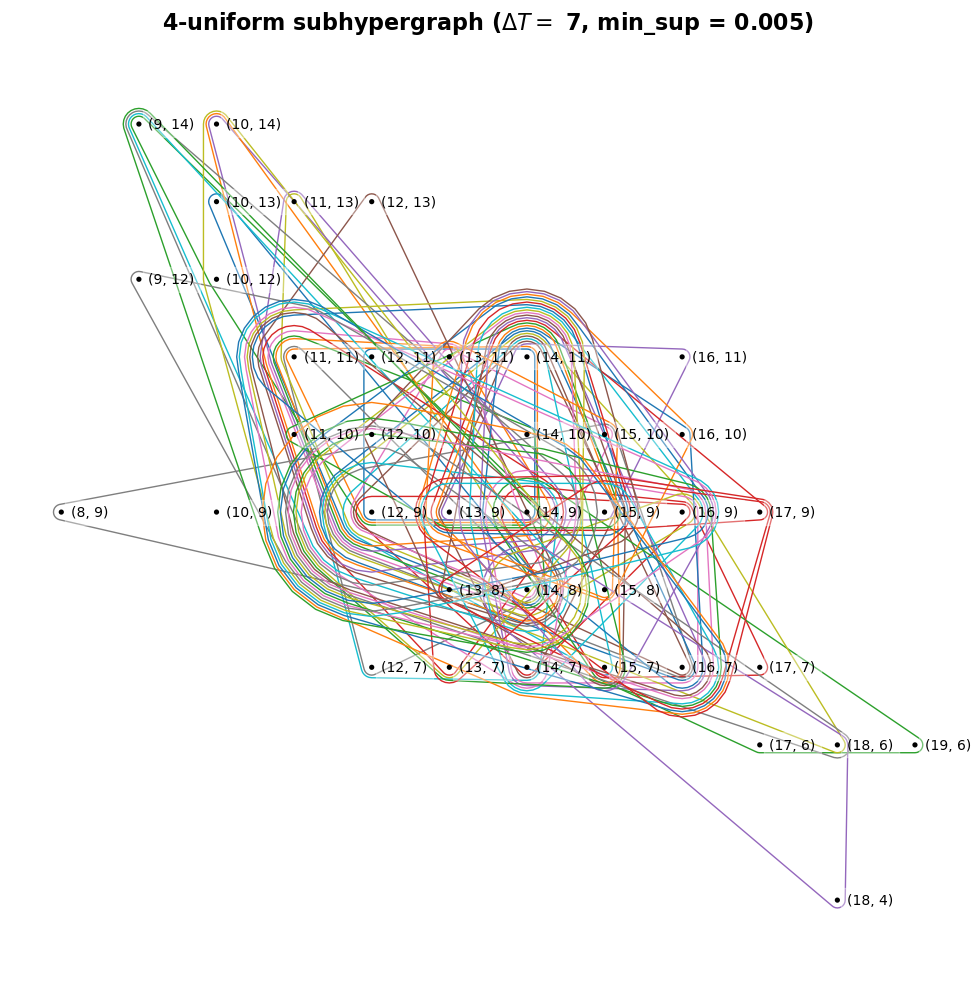

In [40]:
plot_path = f'test.png'
plot_k_uniform_subhypergraph(diff_HG, k, plot_path, DeltaT)

In [41]:
DeltaT = 1
k = 3
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(len(k_uniform_edges))
HG_1 = hnx.Hypergraph({f"e{j}": list(edge) for j, edge in enumerate(k_uniform_edges)})

31


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()


In [42]:
DeltaT = 3
k = 3
min_sup_ind = 1
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges_1 = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(len(k_uniform_edges_1))
HG_2 = hnx.Hypergraph({f"e{j}": list(edge) for j, edge in enumerate(k_uniform_edges_1)})

246


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()


In [43]:
diff_HG = create_difference_hypergraph_edges(k_uniform_edges, k_uniform_edges_1)
k_uniform_edges_diff = {edge: nodes for edge, nodes in diff_HG.incidence_dict.items() if len(nodes) == k}
print(k_uniform_edges_diff)
plot_path = f'test.png'
plot_k_uniform_subhypergraph(diff_HG, k, plot_path, DeltaT)

NameError: name 'create_difference_hypergraph_edges' is not defined

# POI related results

20 20
grouped_x   1    2    3    4    5    6    7    8    9    10   11   12   13  \
grouped_y                                                                    
1          2.0  0.0  2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
2          2.0  2.0  2.0  2.0  NaN  2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0   
3          2.0  2.0  NaN  NaN  NaN  NaN  2.0  2.0  2.0  0.0  2.0  2.0  2.0   
4          2.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN  2.0  2.0  2.0  0.0  2.0   
5          2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  2.0  2.0  2.0   
6          2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  2.0  2.0  2.0   
7          2.0  NaN  NaN  NaN  NaN  2.0  2.0  2.0  2.0  2.0  2.0  2.0  0.0   
8          2.0  NaN  NaN  NaN  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  0.0   
9          2.0  NaN  NaN  NaN  2.0  2.0  2.0  0.0  2.0  2.0  0.0  0.0  0.0   
10         2.0  2.0  NaN  2.0  2.0  NaN  2.0  2.0  2.0  2.0  0.0  0.0  0.0   
11         NaN  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  0.

/Users/user/miniconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/user/miniconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/user/miniconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/Users/user/miniconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `

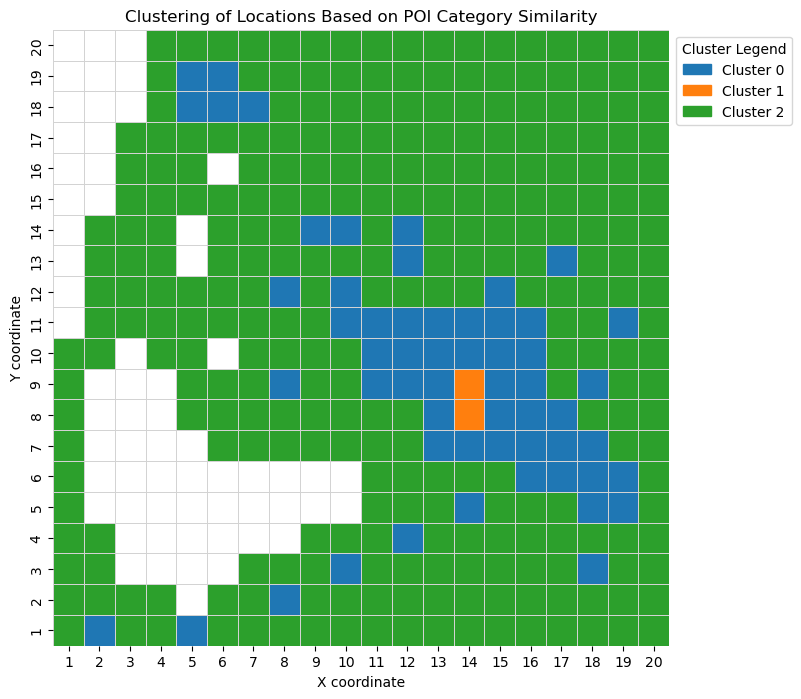

In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

no_clusters = 3
# Group the data by 'grouped_x', 'grouped_y', and 'POIcategory', aggregating POI counts
data = pd.read_csv('YJMob100k/cell_POIcat.csv')  
# Group x and y coordinates to form a 20x20 grid
data['grouped_x'] = (data['x'] -1 ) // 10 + 1
data['grouped_y'] = (data['y'] - 1) // 10 + 1

grouped_data = data.groupby(['grouped_x', 'grouped_y', 'POIcategory']).agg(
    total_POI_count=('POI_count', 'sum')).reset_index()
max_x = grouped_data['grouped_x'].max()
max_y = grouped_data['grouped_y'].max()
print(max_x, max_y)
# Pivot to get each cell as a row, and POI categories as columns
pivot_df = grouped_data.pivot_table(index=['grouped_x', 'grouped_y'], columns='POIcategory',
                                    values='total_POI_count', fill_value=0)

# Scale the data to standardize the range of counts
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivot_df)

# Apply KMeans clustering (adjust number of clusters as needed)
kmeans = KMeans(n_clusters=no_clusters, random_state=42)  # Set n_clusters to the desired number of clusters
pivot_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Reset the index to bring back 'grouped_x' and 'grouped_y' for plotting
pivot_df_reset = pivot_df.reset_index()

# Create a pivot table to map clusters back to the 20x20 grid for heatmap
cluster_map = pivot_df_reset.pivot(index='grouped_y', columns='grouped_x', values='Cluster')
print(cluster_map)

# Define a custom colormap for the clusters
colors = sns.color_palette("tab10", no_clusters)  # Generate a color palette with exactly `n_clusters` colors
cmap = ListedColormap(colors)

# Plotting the clusters
plt.figure(figsize=(10, 8))

# Use the custom colormap
sns_heatmap = sns.heatmap(cluster_map, cmap=cmap, square=True, annot=False, linewidths=0.5, linecolor = 'lightgray',
                          vmin=0, vmax=no_clusters - 1, cbar = False)

# Reverse the y-axis to align it with (0, 0) in the bottom left
plt.gca().invert_yaxis()

# Add a custom legend for clusters
cluster_labels = [f'Cluster {i}' for i in range(no_clusters)]  # Cluster labels like 'Cluster 0', 'Cluster 1', etc.
legend_patches = [Patch(color=colors[i], label=cluster_labels[i]) for i in range(no_clusters)]
plt.legend(handles=legend_patches, title="Cluster Legend", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

# Labels and title
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Clustering of Locations Based on POI Category Similarity')

# Show the plot
plt.show()


In [45]:
print(cluster_map[14][8])

1.0


In [46]:
data = pd.read_csv('YJMob100k/cell_POIcat.csv')  
# Group x and y coordinates to form a 20x20 grid
data['grouped_x'] = (data['x'] -1 ) // 10 + 1
data['grouped_y'] = (data['y'] - 1) // 10 + 1
data.head()

x  y  POIcategory  POI_count  grouped_x  grouped_y
0  1  1           48          4          1          1
1  1  1           58          1          1          1
2  1  1           59          1          1          1
3  1  1           69          2          1          1
4  1  1           73          1          1          1

In [47]:
# Aggregate POI_count in each cell
grouped_data = data.groupby(['grouped_x', 'grouped_y']).agg(total_POI_count=('POI_count', 'sum')).reset_index()
grouped_data.sort_values(by = 'total_POI_count', ascending = False)

grouped_x  grouped_y  total_POI_count
205         14          9            32647
204         14          8            24370
185         13          9            14308
184         13          8            10183
302         19          6             9140
..         ...        ...              ...
47           5         15                2
195         13         19                1
33           4         13                1
70           7          7                1
46           5         12                1

[337 rows x 3 columns]

In [54]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_scatter_for_hypergraphs_from_degrees(grouped_data, degree_counts, deltaT_vals, min_sup_index=0):
    """
    Creates scatter plots for each Delta T value comparing node degree with total POI count.
    
    Parameters:
    grouped_data (DataFrame): Dataframe containing 'grouped_x', 'grouped_y', and 'total_POI_count'.
    degrees (dict): Dictionary where degrees[deltaT][min_sup] gives a dictionary of nodes and their degrees.
    deltaT_vals (list): List of Delta T values to plot.
    min_sup_index (int): Index of min_sup (default is 0 for min_sup = 0.005).
    """
    # Prepare a subplot with three scatter plots
    fig, axes = plt.subplots(1, len(deltaT_vals), figsize=(24, 6), sharey=True)
    
    fig.subplots_adjust(wspace=1.2) 
    
    # Loop through each Delta T value
    for i, deltaT in enumerate(deltaT_vals):
        if deltaT == 1:
            continue
        ax = axes[i]
        
        # Get the degrees for the current Delta T and min_sup
        print(deltaT)
        node_degrees = degree_counts[deltaT][0]
        
        # Map grouped_data to node positions
        total_POI_count = {
            (row['grouped_x'], row['grouped_y']): row['total_POI_count']
            for _, row in grouped_data.iterrows()
        }
        
        # Prepare data for scatter plot
        x_values = []
        y_values = []
        
        # Assume the node degree dictionary corresponds to nodes in the same order as grouped_x, grouped_y in grouped_data
        for idx, row in grouped_data.iterrows():
            node = (row['grouped_x'], row['grouped_y'])
            if node in node_degrees and node in total_POI_count:
                degree = node_degrees[node]  # Node degree
                total_POI = total_POI_count[node]  # Total POI count
                x_values.append(degree)
                y_values.append(total_POI)
        
       # Convert to numpy arrays for linear regression
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        
        # Avoid log(0) and log(negative values) issues by filtering out non-positive values
        valid_indices = (x_values > 0) & (y_values > 0)
        x_values = x_values[valid_indices]
        y_values = y_values[valid_indices]
        
        # Take the log of the x and y values
        log_x = np.log(x_values)
        log_y = np.log(y_values)
        
        # Perform linear regression on the log-transformed data
        slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
        
        # Create scatter plot
        ax.scatter(x_values, y_values, alpha=0.6, edgecolor = 'black', label="Data Points")
        
        # Plot the fitted line
        ax.plot(x_values, np.exp(intercept) * x_values**slope, color='black', 
                linestyle='dotted', label=f"Fit: y = {np.exp(intercept):.2f} * x^{slope:.2f}")
        
        ax.set_title(f"ΔT = {deltaT}", fontsize=20)
        ax.set_xlabel("Node Degree", fontsize=18)
        
        x_ticks = [1, 10, 100, 1000, 10000, 100000]  # Example tick values
        y_ticks = [1, 10, 100, 1000, 10000, 100000]  # Example tick values
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([str(tick) for tick in x_ticks], fontsize=14)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([str(tick) for tick in y_ticks], fontsize=14)
        

        if i == 0:
            ax.set_ylabel("Total POI Count", fontsize=18)
        
        # Set log scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        # Add legend
        ax.legend(loc='best', fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('node_degree_vs_poi_count.png',dpi=600)
    plt.show()

3
7


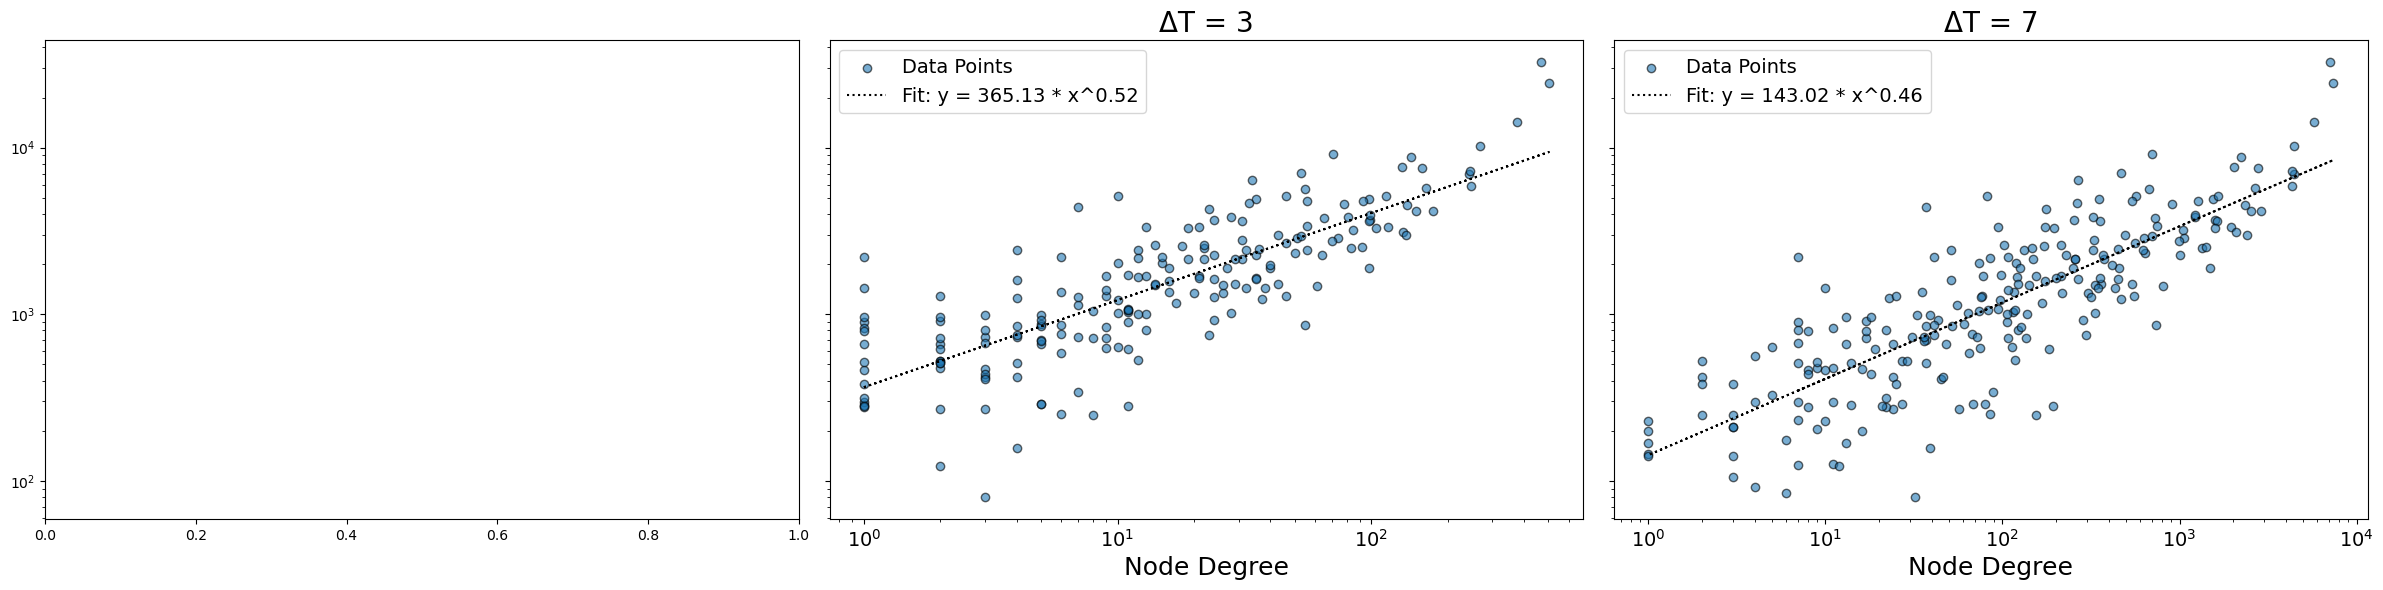

In [55]:
plot_scatter_for_hypergraphs_from_degrees(grouped_data, degree_counts, deltaT_vals)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(x, a, b):
    """Power-law function: y = a * x^b"""
    return a * x**b

def plot_scatter_with_power_law_fit(grouped_data, degree_counts, deltaT_vals, min_sup_index=0):
    """
    Creates scatter plots for each Delta T value comparing node degree with total POI count,
    and fits a power-law relationship.
    
    Parameters:
    grouped_data (DataFrame): Dataframe containing 'grouped_x', 'grouped_y', and 'total_POI_count'.
    degree_counts (dict): Dictionary where degree_counts[deltaT][min_sup] gives a dictionary of nodes and their degrees.
    deltaT_vals (list): List of Delta T values to plot.
    min_sup_index (int): Index of min_sup (default is 0 for min_sup = 0.005).
    """
    # Prepare a subplot with three scatter plots
    fig, axes = plt.subplots(1, len(deltaT_vals), figsize=(18, 6), sharey=True)

    # Loop through each Delta T value
    for i, deltaT in enumerate(deltaT_vals):
        ax = axes[i]
        
        # Get the degrees for the current Delta T and min_sup
        node_degrees = degree_counts[deltaT][min_sup_index]
        
        # Map grouped_data to node positions
        total_POI_count = {
            (row['grouped_x'], row['grouped_y']): row['total_POI_count']
            for _, row in grouped_data.iterrows()
        }
        
        # Prepare data for scatter plot
        x_values = []
        y_values = []
        
        # Extract data for scatter plot
        for idx, row in grouped_data.iterrows():
            node = (row['grouped_x'], row['grouped_y'])
            if node in node_degrees and node in total_POI_count:
                degree = node_degrees[node]  # Node degree
                total_POI = total_POI_count[node]  # Total POI count
                if degree > 0 and total_POI > 0:  # Avoid log(0) errors
                    x_values.append(degree)
                    y_values.append(total_POI)
        
        # Scatter plot in log-log space
        ax.scatter(x_values, y_values, alpha=0.6, edgecolor='black', label='Data')
        
        # Fit power-law to data in log-log space
        if len(x_values) > 0:
            log_x = np.log10(x_values)
            log_y = np.log10(y_values)
            
            # Perform linear fit in log-log space
            popt, _ = curve_fit(power_law, x_values, y_values)
            a, b = popt
            
            # Generate power-law fit line
            x_fit = np.linspace(min(x_values), max(x_values), 100)
            y_fit = power_law(x_fit, a, b)
            
            # Plot the fit
            ax.plot(x_fit, y_fit, color='red', linestyle='--', 
                    label=f"Fit: y = {a:.2f} * x^{b:.2f}")
        
        # Log-log scale
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        # Titles and labels
        ax.set_title(f"ΔT = {deltaT}", fontsize=16)
        ax.set_xlabel("Node Degree", fontsize=14)
        if i == 0:
            ax.set_ylabel("Total POI Count", fontsize=14)
        
        # Add legend
        ax.legend(fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [ ]:
plot_scatter_with_power_law_fit(grouped_data, degree_counts, deltaT_vals)

In [ ]:
import hypernetx as hnx
import hypergraphx as hgx
from hypergraphx.measures.eigen_centralities import CEC_centrality

def convert_hypernetx_to_hypergraphx(hnx_hypergraph):
    """
    Converts a HyperNetX hypergraph to a HypergraphX hypergraph.
    Maps original node labels (x, y) to sequential integer indices used in HypergraphX.
    
    Parameters:
    hnx_hypergraph (HyperNetX Hypergraph): The original HyperNetX hypergraph.
    
    Returns:
    hgx_hypergraph (HypergraphX Hypergraph): The converted HypergraphX hypergraph.
    node_mapping (dict): Mapping from HypergraphX indices to original node labels.
    """
    hgx_hypergraph = hgx.Hypergraph()
    node_mapping = {}

    # Create a node mapping: (x, y) to HyperGraphX index
    node_idx = 0  # Start with index 0 for HyperGraphX nodes
    for node in hnx_hypergraph.nodes:
        hgx_hypergraph.add_node(node_idx)
        node_mapping[node_idx] = node  # Map HyperGraphX index to (x, y) coordinate
        node_idx += 1

    # Add hyperedges, using the node indices mapped from (x, y) coordinates
    for edge, nodes in hnx_hypergraph.incidence_dict.items():
        # Map each (x, y) node to the corresponding HyperGraphX index
        edge_nodes = [idx for idx, node in enumerate(hnx_hypergraph.nodes) if node in nodes]
        hgx_hypergraph.add_edge(edge_nodes)  # Add the edge with integer indices

    return hgx_hypergraph, node_mapping

In [ ]:
hgx_H_k_uniform, node_mapping = convert_hypernetx_to_hypergraphx(H_k_uniform)

In [ ]:
centrality_dict = CEC_centrality(hgx_H_k_uniform)

# Remap centrality_dict to use original labels
original_centrality_dict = {node_mapping[node]: score for node, score in centrality_dict.items()}

# Print results with original node labels
for node, score in original_centrality_dict.items():
    print(f"Node {node}: CEC Centrality = {score}")


In [ ]:
centrality_dict

In [ ]:
hgx_H_k_uniform.get_nodes()

In [ ]:
DeltaT = 7
k = 7
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
hgx_H_k_uniform, node_mapping = convert_hypernetx_to_hypergraphx(HG_deltaT_1[0])
motifs = compute_motifs(hgx_H_k_uniform, order=3, runs_config_model=10)

In [ ]:
motifs